# notebook 3 - batch correction

This notebook will introduce you very briefly to the process of batch correction using another dataset extracted from Kotliarov et al. 2020 Nature Medicine:

Broad immune activation underlies shared set point signatures for vaccine responsiveness in healthy individuals and disease activity in patients with lupus
(https://www.nature.com/articles/s41591-020-0769-8)


In [2]:
#import necessary python packages
import scanpy as sc #software suite of tools for single-cell analysis in python
import besca as bc #internal BEDA package for single cell analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import besca as bc

sc.logging.print_header() #output an overview of the software versions that are loaded

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.2


In [3]:
from IPython.display import HTML
task = "<style>div.task { background-color: #ffc299; border-color: #ff944d; border-left: 7px solid #ff944d; padding: 1em;} </style>"
HTML(task)

In [4]:
tag = "<style>div.tag { background-color: #99ccff; border-color: #1a8cff; border-left: 7px solid #1a8cff; padding: 1em;} </style>"
HTML(tag)

In [5]:
FAIR = "<style>div.fair { background-color: #d2f7ec; border-color: #d2f7ec; border-left: 7px solid #2fbc94; padding: 1em;} </style>"
HTML(FAIR)

## Dataset

Here we will reload the dataset we wrote out after performing the regressout to perform a batch correction on Donor.

In [6]:
adata = bc.datasets.Kotliarov2020_processed()

In [7]:
adata

AnnData object with n_obs × n_vars = 47511 × 1271
    obs: 'CELL', 'CONDITION', 'sample_type', 'donor', 'tenx_lane', 'cohort', 'batch', 'sampleid', 'timepoint', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'protein_leiden', 'leiden_r1.0', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'celltype_flowjo'
    var: 'ENSEMBL', 'SYMBOL', 'feature_type', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'celltype0_colors', 'celltype1_colors', 'celltype2_colors', 'celltype3_colors', 'celltype_flowjo_colors', 'leiden', 'leiden_colors', 'leiden_r1.0_colors', 'neighbors', 'protein_leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'protein', 'protein_umap'
    obsp: 'connectivities', 'distances'

## Batch correction

After normalization, there could still be confounders in the data. Technical confounders (batch effects) can arise from difference in reagents, isolation methods, the lab/experimenter who performed the experiment, even which day/time the experiment was performed. Further factors like cell size, cell cycle phase , etc. can introduce unwanted variance in your data that may not be of biological interest. Various approaches exist that can account for and, ideally, remove technical confounders, this is called a **batch correction**. In general technical confounders can only be removed if the **batch effect is orthogonal to the biological differences in each batch**! In cases were this is not the case applying a batch correction does not make sense since you will never be able to differentiate if the result of significant differences are due to the batch or true biological differences. 



Here we will discuss a batch correction based on the **Batch balanced KNN** (in python bbknn) since this is the one we most commonly use, but there are many other approaches as well.


In [8]:
adata.obs.batch.value_counts()

1    24593
2    22918
Name: batch, dtype: int64

In [9]:
#rename the Donors
adata.obs.batch = adata.obs.batch.to_frame().replace({1:'batch_1' , 2:'batch_2'}).batch

## perform the  dataprocessing pipeline

### principle component analysis

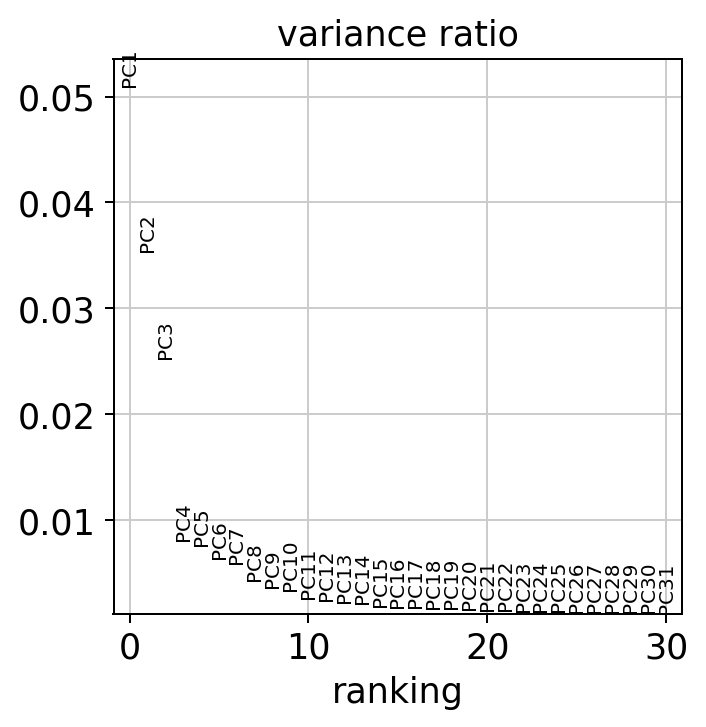

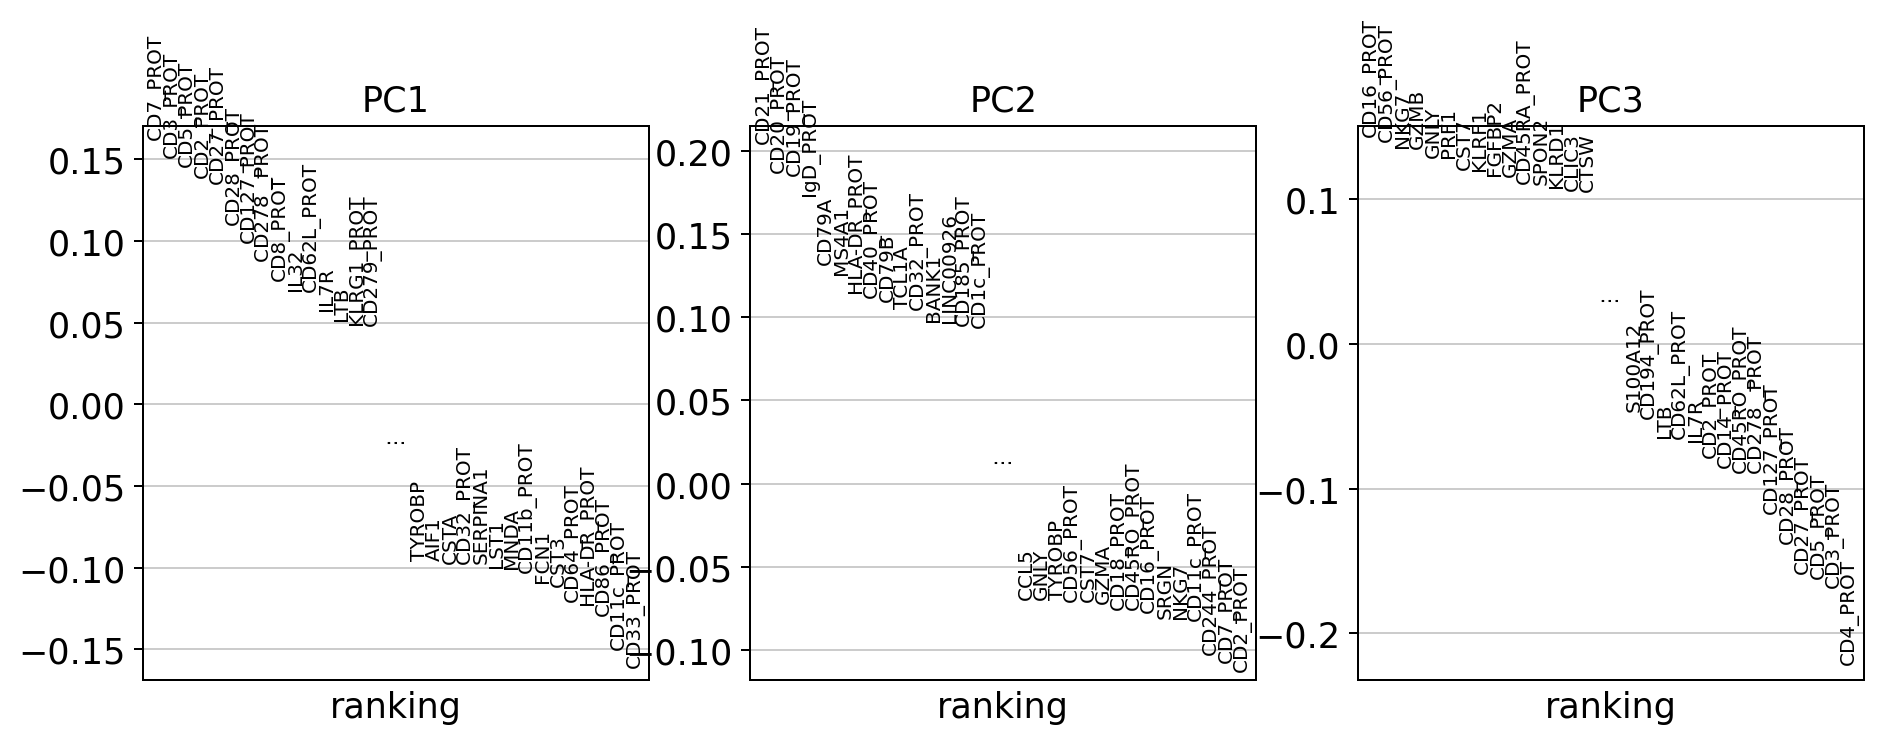

In [10]:
#define random seed
random_seed = 0

sc.settings.set_figure_params(dpi=90)

#calculate 50 principle components of the dataset
sc.tl.pca(adata, random_state=random_seed, svd_solver='arpack')

#visualize the amount of variance explained by each PC
sc.pl.pca_variance_ratio(adata)

#visualize the loadings onto the first 3 PCs
sc.pl.pca_loadings(adata)

In [11]:
adata_uncorrected = adata.copy()
import bbknn
bbknn.bbknn(adata, batch_key='batch') #perform alternative batch correction method
#sc.pp.neighbors(adata, n_neighbors=15, random_state = random_seed, n_pcs=50, )

#### Leiden clustering

In [12]:
sc.tl.leiden(adata, random_state=random_seed)

### UMAP & t-SNE

In [13]:
%%time
sc.tl.umap(adata, random_state = random_seed)

CPU times: user 40.2 s, sys: 1.01 s, total: 41.2 s
Wall time: 37.8 s


In [14]:
%%time
sc.tl.tsne(adata, random_state = random_seed)

CPU times: user 13min 13s, sys: 12 s, total: 13min 25s
Wall time: 7min 35s


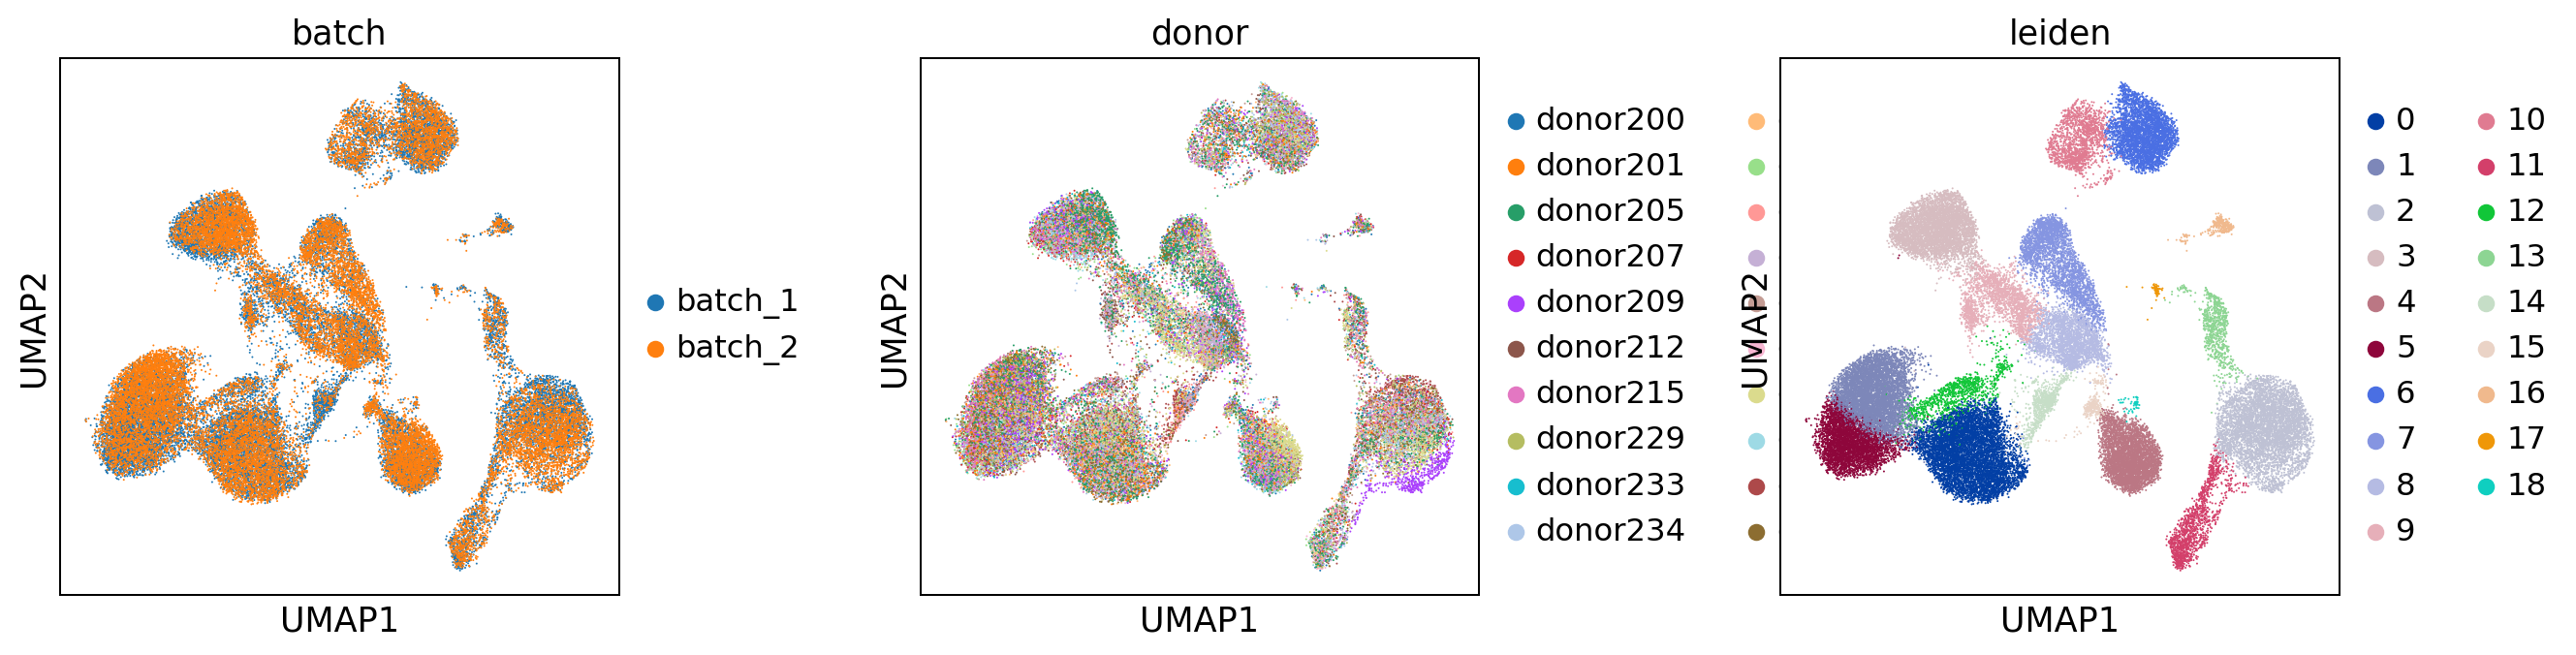

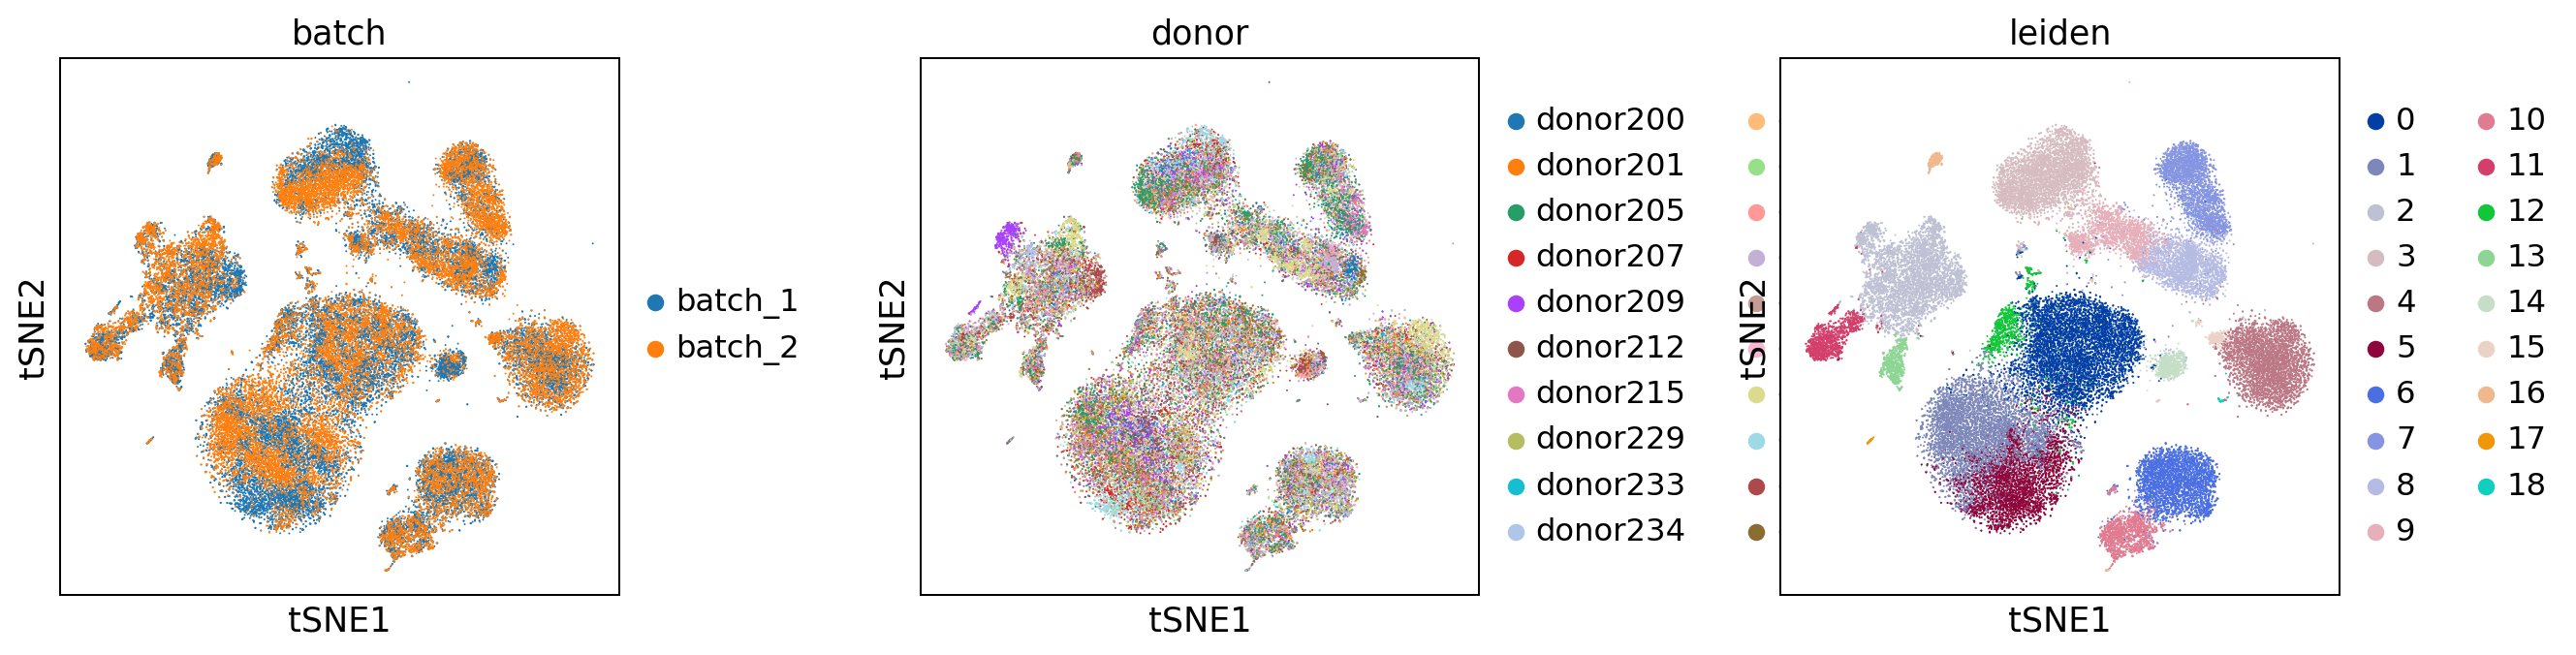

In [15]:
sc.pl.umap(adata, color = ['batch', 'donor', 'leiden'], wspace = 0.4)
sc.pl.tsne(adata, color = ['batch', 'donor', 'leiden'], wspace = 0.4)

## Comparision with uncorrected dataset

In [16]:
#read in uncorrected dataset

sc.pp.neighbors(adata_uncorrected, n_neighbors=15, random_state = random_seed, n_pcs=50)

uncorrected


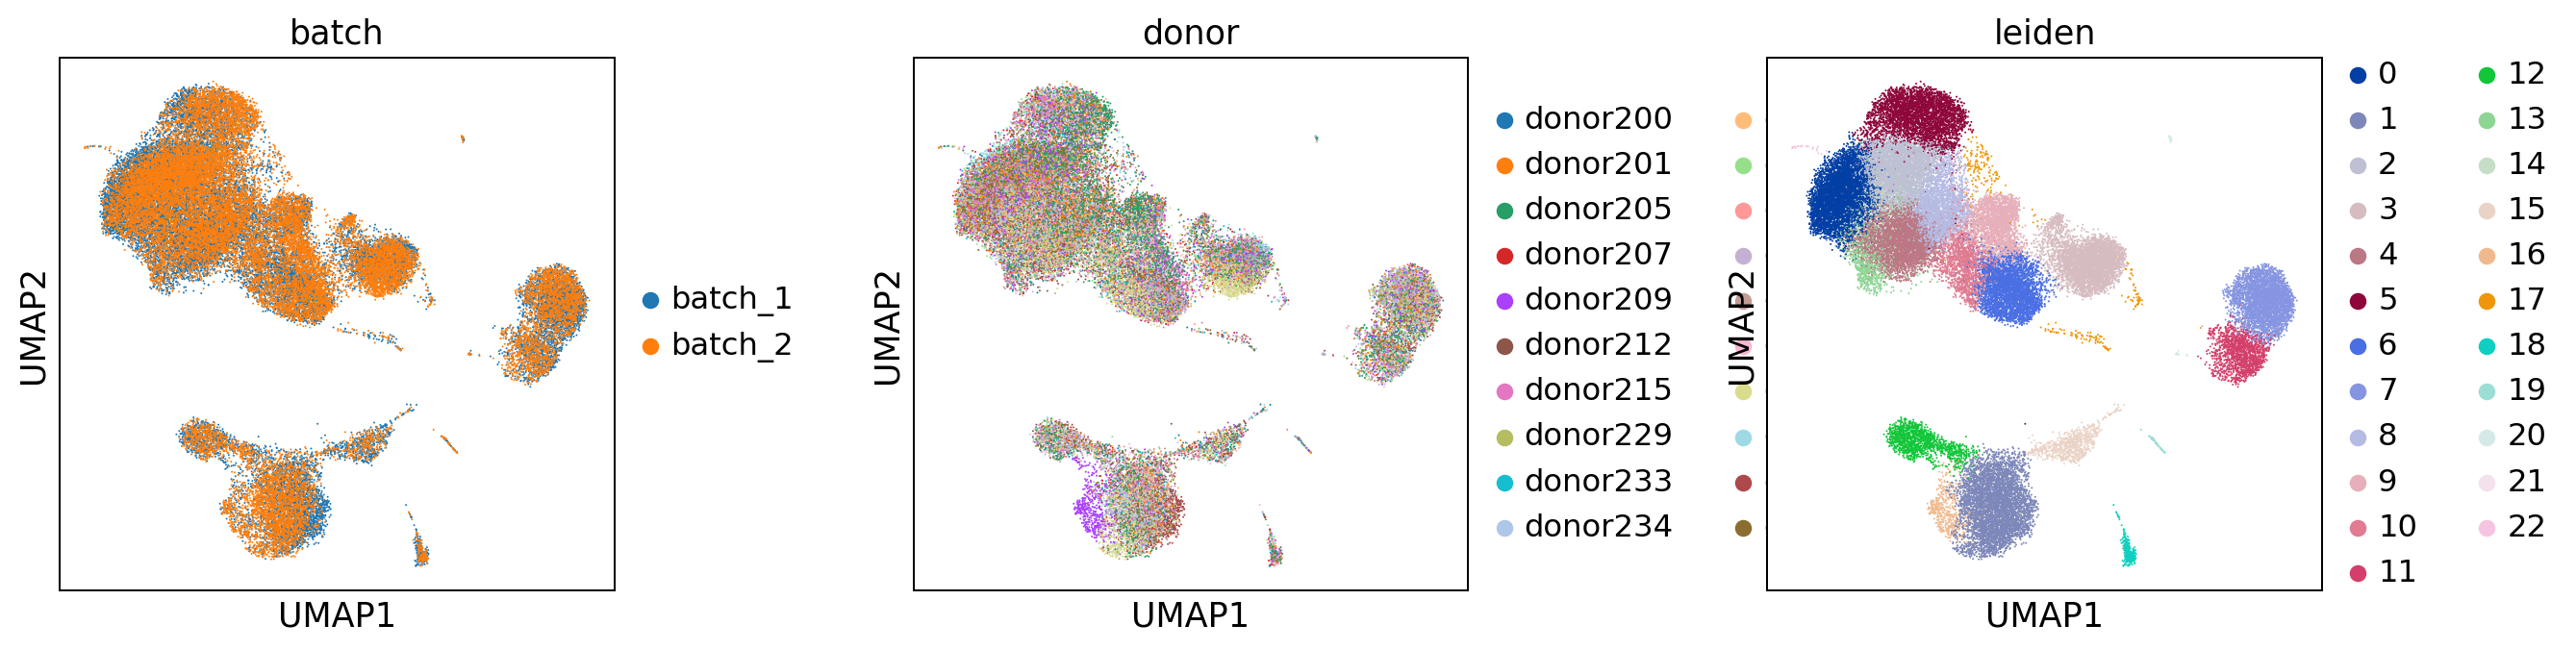

corrected


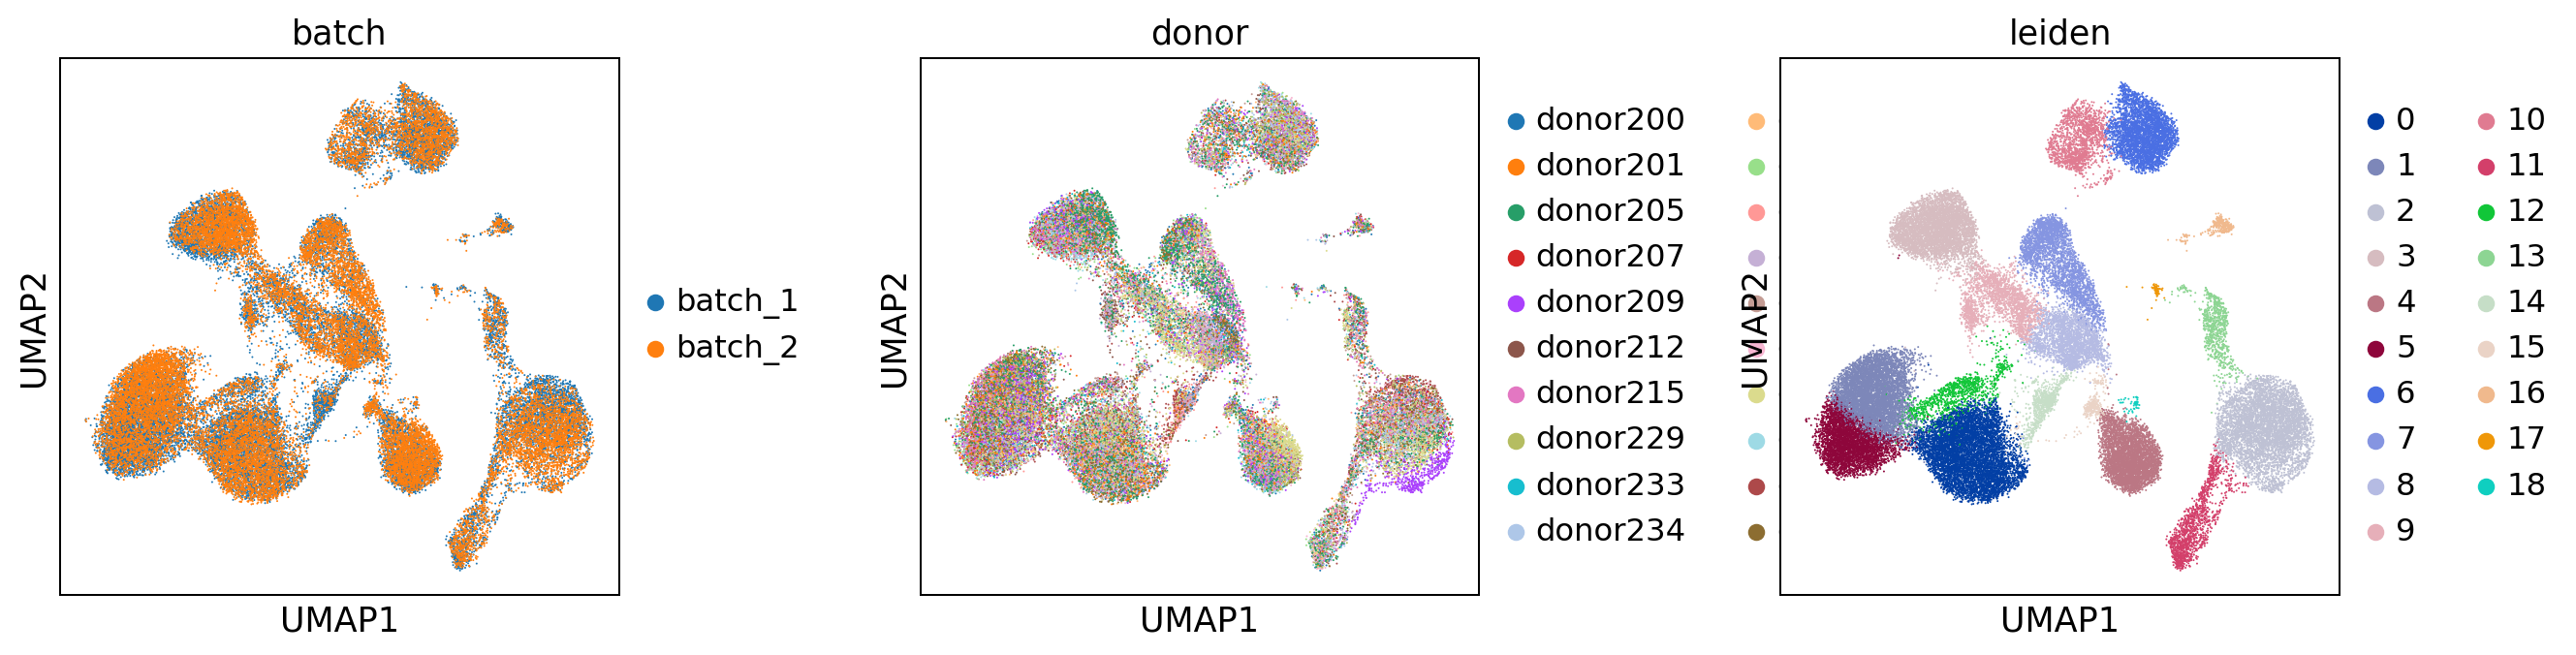

In [17]:
##comparision of louvain clustering with unbatchcorrected dataset
print('uncorrected')
sc.pl.umap(adata_uncorrected, color = ['batch' , 'donor', 'leiden'], wspace = 0.4)
print('corrected')
sc.pl.umap(adata, color = ['batch' , 'donor', 'leiden'], wspace = 0.4)

uncorrected


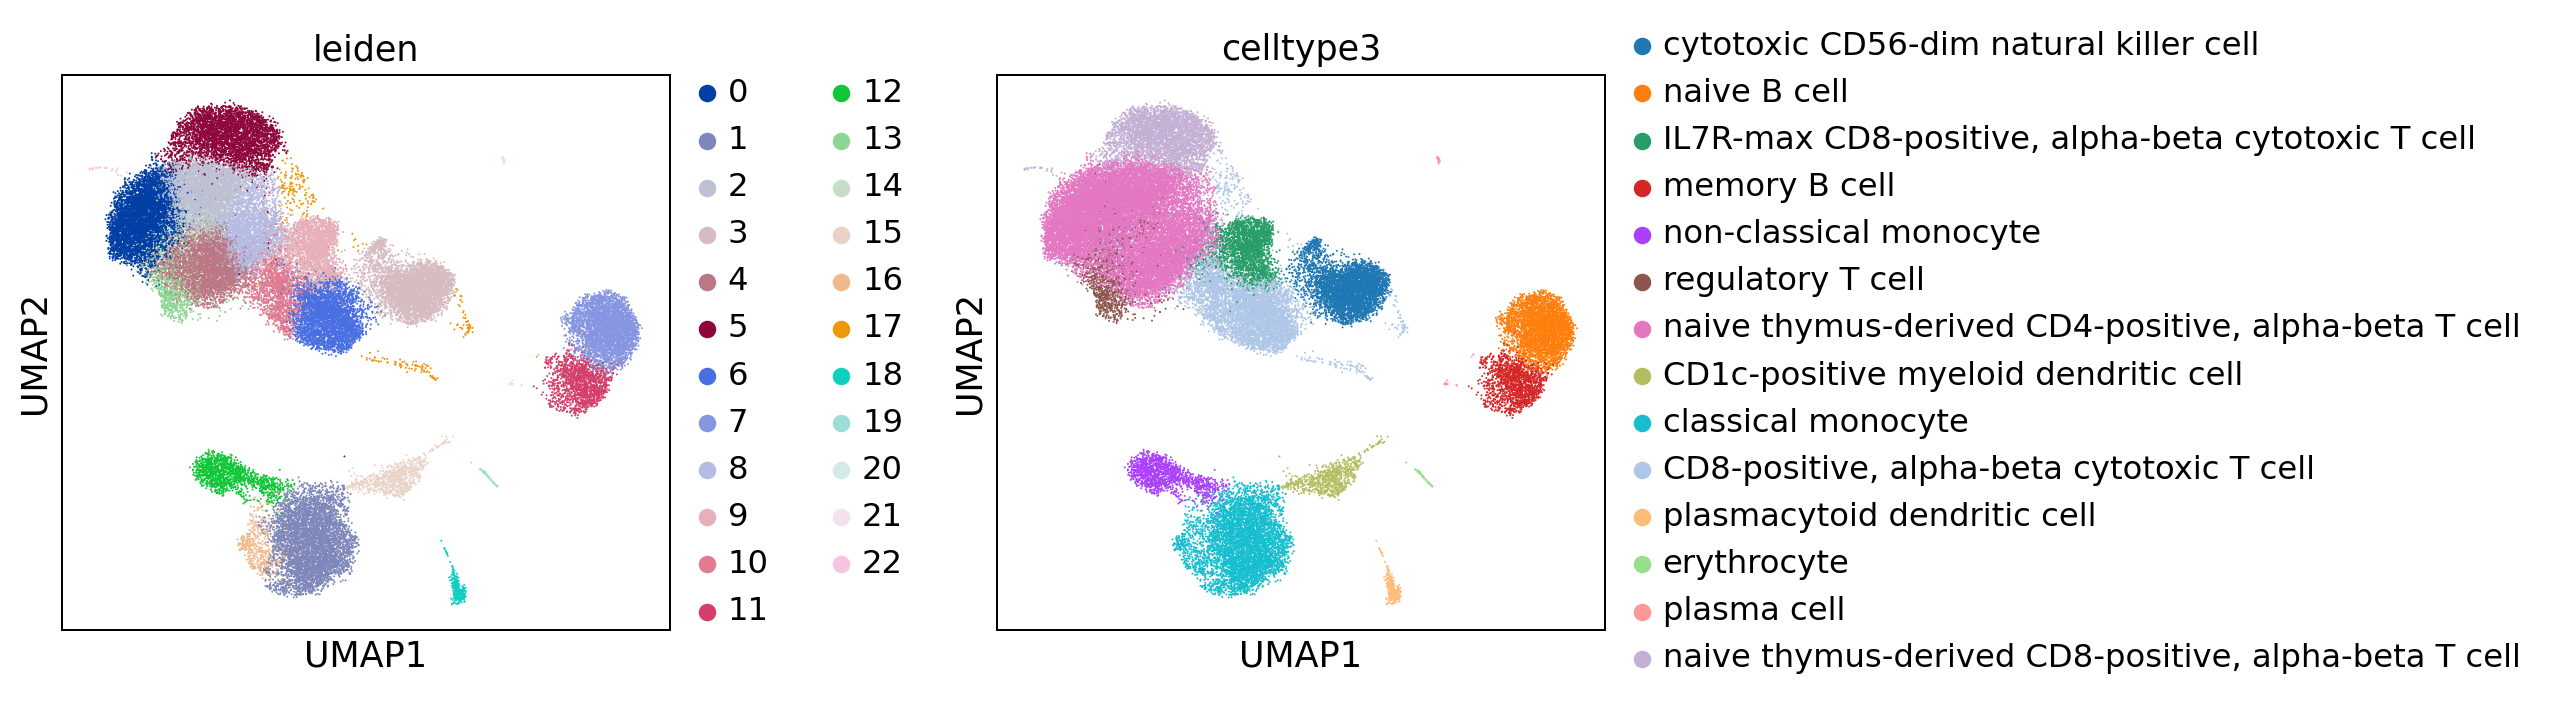

corrected


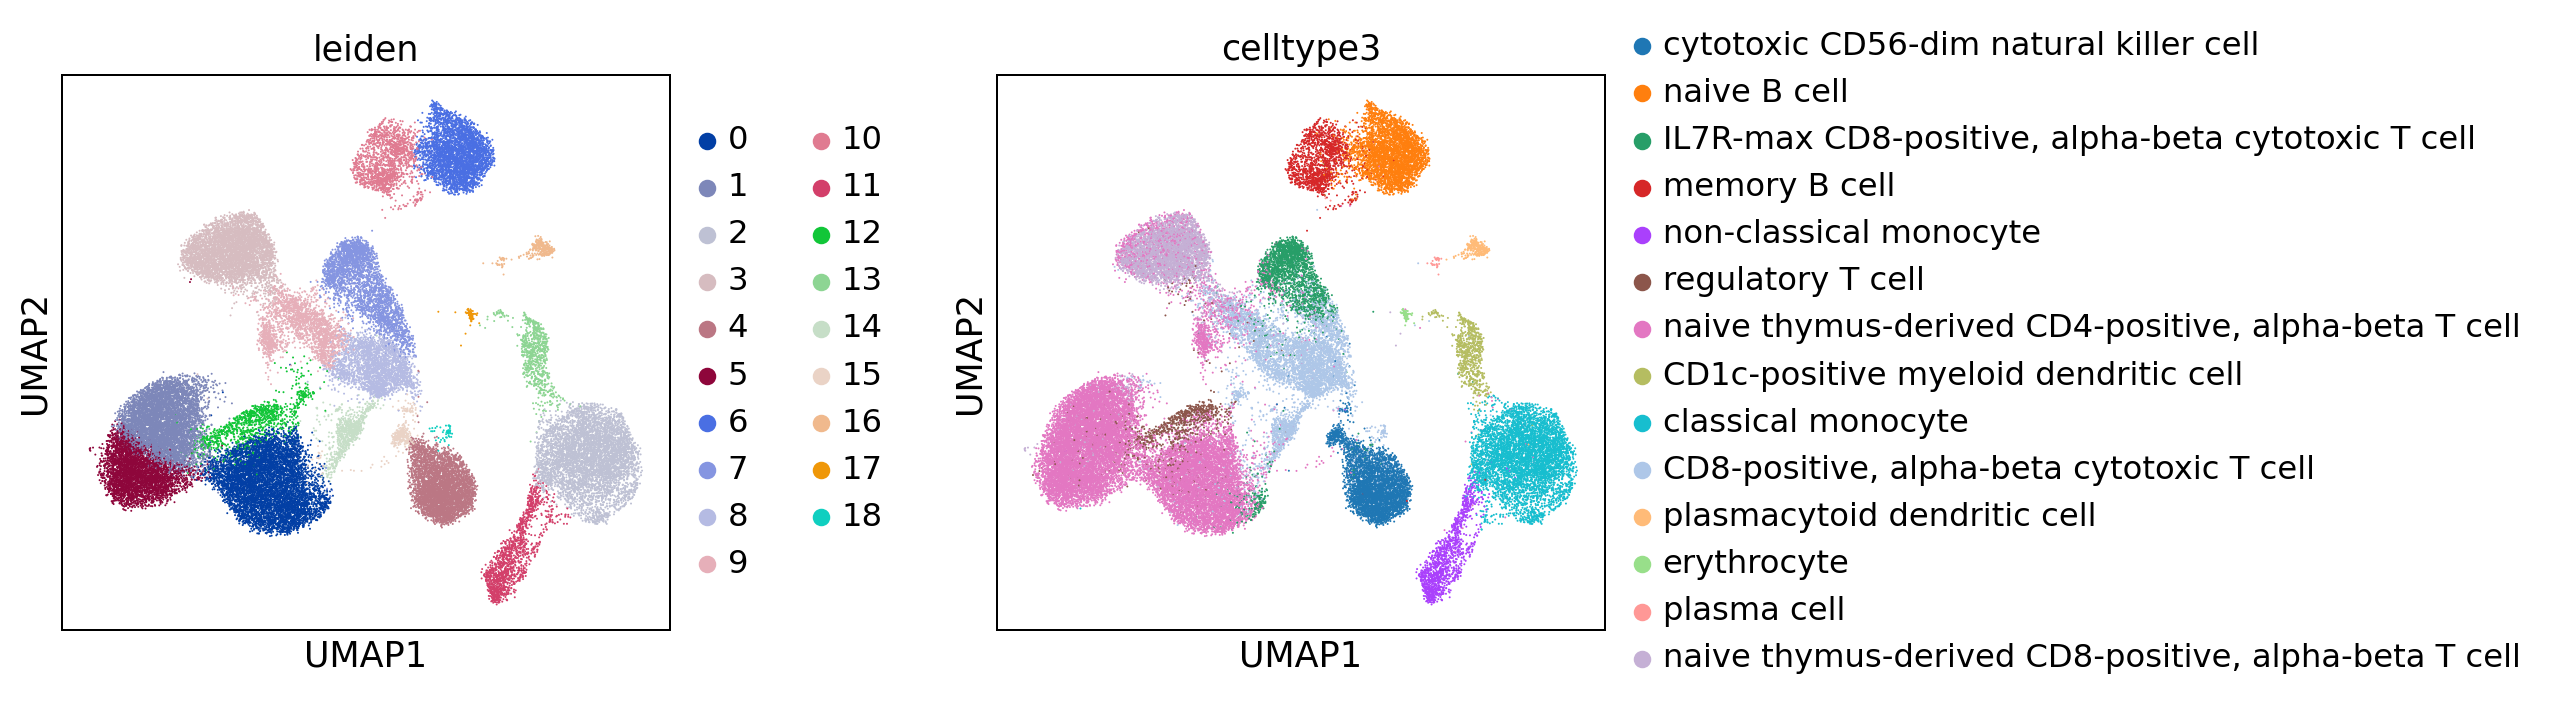

In [18]:
print('uncorrected')
sc.pl.umap(adata_uncorrected, color = ['leiden', 'celltype3'], wspace = 0.4)
print('corrected')
sc.pl.umap(adata, color = ['leiden', 'celltype3'], wspace = 0.4)